# Immorthon

In [1]:
!pip install transformers
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2


In [1]:
import pandas as pd

dicoName = "dico.csv"

# cloner si on est sur colab
if 'google.colab' in str(get_ipython()):
  !git clone https://github.com/sully-vian/immorthon.git
  dicoPath = "immorthon/" + dicoName
else:
  dicoPath = "./" + dicoName

df = pd.read_csv(dicoPath)
df["text"] = "Define: " + df["word"] + "\n" + df["definition"]

ParserError: Error tokenizing data. C error: Expected 2 fields in line 1297, saw 3


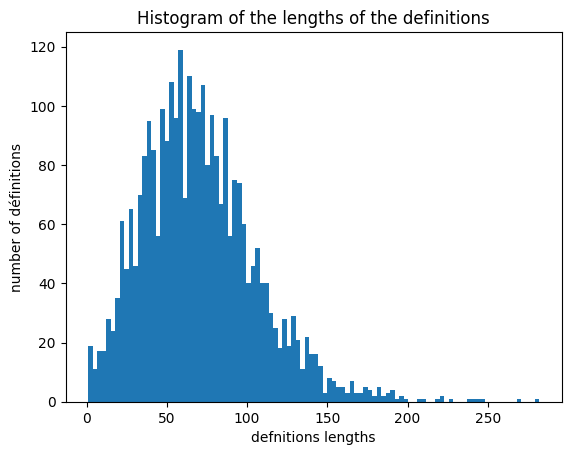

In [6]:
import matplotlib.pyplot as plt

definition_lengths = [len(definition) for definition in df["definition"]]
plt.hist(definition_lengths, bins=100)
plt.title('Histogram of the lengths of the definitions')
plt.xlabel('defnitions lengths')
plt.ylabel('number of définitions')
plt.show()

In [7]:
from datasets import Dataset

dataset = Dataset.from_pandas(df[["text"]])
# séparer aléatoirement la data en train et test
splitDataset = dataset.train_test_split(test_size=0.1)

In [12]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# par ordre croissant de taille
modelNames = [
    "distilgpt2",
    "gpt2",
    "databricks/dolly-v2-3b" # trop lourd pour un T4 GPU
]
modelName = modelNames[0]
tokenizer = AutoTokenizer.from_pretrained(modelName)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(modelName)

def tokenize(example):
    encoding = tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=32
    )
    encoding["labels"] = encoding["input_ids"].copy()
    return encoding

tokenizedDataset = splitDataset.map(tokenize, batched=True)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Map:   0%|          | 0/2689 [00:00<?, ? examples/s]

Map:   0%|          | 0/299 [00:00<?, ? examples/s]

In [13]:
from transformers import TrainingArguments, Trainer

trainingArgs = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="no",
    save_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=trainingArgs,
    train_dataset=tokenizedDataset["train"],
    eval_dataset=tokenizedDataset["test"],
    tokenizer=tokenizer,
)

trainer.train()

<ipython-input-13-eb22fd972da1>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


RuntimeError: Bad StatusOr access: RESOURCE_EXHAUSTED: Error allocating device buffer: Attempting to allocate 147.26M. That was not possible. There are 66.84M free.; (0x0x0_HBM0)

In [49]:
from transformers.pipelines import pipeline

generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

def generate(prompt, numDef):
    fullPrompt = "Define: " + prompt
    results = generator(fullPrompt, max_length=32, num_return_sequences=numDef, do_sample=True, temperature=0.7)
    return [result["generated_text"] for result in results]

for result in generate("doof", 3):
    print(result, end="\n\n")

Device set to use cuda:0


Define: doof
to take somebody/something for a particular purpose

Define: doofine
used to refer to somebody or something that is not the same as another person, thing, etc.

Define: doof
to say something that is done

